In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from scipy import stats

# Define Trial Parameters
TRIAL_START_DATE = '2019-02-01'
TRIAL_STORES = [77, 86, 88]
# Define a small epsilon to prevent division by zero in standardization
EPSILON = 1e-6 

# --- 1. Load and Inspect Data ---
df_qvi = pd.read_csv(r"\Users\asus\Downloads\QVI_data.csv")


print(df_qvi.head())

df_qvi.info()

#  Data Preparation and Monthly KPI Calculation 
# Convert DATE to datetime objects
df_qvi['DATE'] = pd.to_datetime(df_qvi['DATE'])
# Ensure all sales are positive or zero (cleaning step)
df_qvi = df_qvi[df_qvi['TOT_SALES'] >= 0]
# Use LYLTY_CARD_NBR for customers, TXN_ID for transactions.
df_qvi['YEAR_MONTH'] = df_qvi['DATE'].dt.to_period('M')

# Calculate Monthly KPIs per Store
monthly_data = df_qvi.groupby(['STORE_NBR', 'YEAR_MONTH']).agg(
    Monthly_Total_Sales=('TOT_SALES', 'sum'),
    Monthly_Total_Customers=('LYLTY_CARD_NBR', 'nunique'),
    Monthly_Total_Transactions=('TXN_ID', 'nunique')
).reset_index()

# Calculate Average Transactions per Customer
# Handle division by zero for stores with 0 customers, though unlikely in aggregated monthly data
monthly_data['Monthly_Avg_Transactions'] = np.where(
    monthly_data['Monthly_Total_Customers'] > 0,
    monthly_data['Monthly_Total_Transactions'] / monthly_data['Monthly_Total_Customers'],
    0
)

#  Filter for Pre-Trial Period 
# Convert TRIAL_START_DATE to Period('M') for comparison
TRIAL_START_PERIOD = pd.to_datetime(TRIAL_START_DATE).to_period('M')
pre_trial_data = monthly_data[monthly_data['YEAR_MONTH'] < TRIAL_START_PERIOD]

print("\nMonthly data preparation complete. Head of pre_trial_data:")
print(pre_trial_data.head())

   LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000  2018-10-17          1       1         5   
1            1002  2018-09-16          1       2        58   
2            1003  2019-03-07          1       3        52   
3            1003  2019-03-08          1       4       106   
4            1004  2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
4          WW Original Stacked Chips 160g         1        1.9        160   

        BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0     NATURAL  YOUNG SINGLES/COUPLES          Premium  
1         RRD  YOUNG SINGLES/COUPLES       Mainstrea

In [3]:
# Control Store Selection Function 

def select_control(trial_store_id, pre_trial_data, trial_stores, epsilon):
    """
    Selects the best control store based on sales correlation and magnitude distance 
    during the pre-trial period, incorporating a robustness check (epsilon) 
    to handle zero variance.
    """
    
    # 1. Filter trial store data
    trial_store_data = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store_id].sort_values('YEAR_MONTH')
    
    # 2. Filter potential control candidates (must not be a trial store)
    control_candidates = pre_trial_data[~pre_trial_data['STORE_NBR'].isin(trial_stores)]

    best_match = {'store_id': None, 'corr': -1, 'distance_norm': float('inf')}
    
    # Iterate through all potential control stores
    for control_store_id in control_candidates['STORE_NBR'].unique():
        control_store_data = control_candidates[
            control_candidates['STORE_NBR'] == control_store_id
        ].sort_values('YEAR_MONTH')

        # Ensure both dataframes cover the same months (Crucial step for alignment)
        merged_data = pd.merge(
            trial_store_data[['YEAR_MONTH', 'Monthly_Total_Sales']],
            control_store_data[['YEAR_MONTH', 'Monthly_Total_Sales']],
            on='YEAR_MONTH',
            suffixes=('_trial', '_control')
        )
        
        # Check if there's enough common data (must have more than 1 month)
        if len(merged_data) > 1:
            # Metric 1: Pearson Correlation (Trend Similarity)
            sales_corr = merged_data['Monthly_Total_Sales_trial'].corr(
                merged_data['Monthly_Total_Sales_control']
            )
            
            #Metric 2: Magnitude Distance (Level Similarity) using standardized sales
            
            #Calculate mean and standard deviation for normalization
            trial_mean = merged_data['Monthly_Total_Sales_trial'].mean()
            trial_std = merged_data['Monthly_Total_Sales_trial'].std()
            control_mean = merged_data['Monthly_Total_Sales_control'].mean()
            control_std = merged_data['Monthly_Total_Sales_control'].std()

            # Robust Standardization: Add epsilon to prevent division by zero
            trial_sales_norm = (merged_data['Monthly_Total_Sales_trial'] - trial_mean) / (trial_std + epsilon)
            control_sales_norm = (merged_data['Monthly_Total_Sales_control'] - control_mean) / (control_std + epsilon)
            
            # Euclidean Distance
            # No need to fillna(0) if data is aligned and standardized correctly, 
            magnitude_distance = euclidean(trial_sales_norm.dropna(), control_sales_norm.dropna())
            
            # Selection Logic 
            # Prioritize high correlation AND low magnitude distance
            # Lowering the correlation threshold to 0.7 for better candidate inclusion, 
            # but still prioritizing low distance among high correlators.
            if sales_corr > 0.7: 
                if magnitude_distance < best_match['distance_norm']:
                    best_match['store_id'] = control_store_id
                    best_match['corr'] = sales_corr
                    best_match['distance_norm'] = magnitude_distance
    
    
    return best_match

# run function for all trial stores
control_mapping = {}
for store in TRIAL_STORES:
    result = select_control(store, pre_trial_data, TRIAL_STORES, EPSILON)
    control_mapping[store] = result

print("\n--- Control Store Selection Results ---")
for trial, match in control_mapping.items():
    if match['store_id'] is not None:
        print(f"Trial Store {trial}: Best Control Store is {match['store_id']} (Correlation: {match['corr']:.3f}, Distance: {match['distance_norm']:.3f})")
    else:
        print(f"Trial Store {trial}: No suitable control store found (Correlation > 0.7 requirement failed).")


--- Control Store Selection Results ---
Trial Store 77: Best Control Store is 31 (Correlation: 1.000, Distance: 0.000)
Trial Store 86: Best Control Store is 31 (Correlation: 1.000, Distance: 0.000)
Trial Store 88: Best Control Store is 159 (Correlation: 0.903, Distance: 1.078)


In [4]:
# Trial Assessment Function 

# Re-filter the full monthly data for the trial period
trial_period_data = monthly_data[monthly_data['YEAR_MONTH'] >= TRIAL_START_PERIOD].copy()

def assess_trial_impact(trial_store, control_store, trial_data):
    """
    Compares metrics between trial and control store during the trial period 
    using a T-test and calculates percentage lift/drop.
    """
    
    # 1. Prepare data for comparison
    trial_store_metrics = trial_data[trial_data['STORE_NBR'] == trial_store]
    control_store_metrics = trial_data[trial_data['STORE_NBR'] == control_store]
    
    # List of KPIs to test
    kpis = ['Monthly_Total_Sales', 'Monthly_Total_Customers', 'Monthly_Avg_Transactions']
    results = {'Trial_Store': trial_store, 'Control_Store': control_store}

    for kpi in kpis:
        # T-Test (Comparing the mean of the KPI during the trial period)
        # Handle cases where data might be missing for a store in the trial period (though unlikely)
        trial_values = trial_store_metrics[kpi].fillna(0)
        control_values = control_store_metrics[kpi].fillna(0)
        
        # Check if there is data to compare
        if len(trial_values) > 1 and len(control_values) > 1:
            t_stat, p_value = stats.ttest_ind(
                trial_values,
                control_values,
                equal_var=False # Welch's t-test (robust)
            )
            
            # Mean difference calculation
            mean_trial = trial_values.mean()
            mean_control = control_values.mean()
            
            # Percentage Lift/Drop (Handle division by zero in control mean calculation)
            pct_change = ((mean_trial - mean_control) / (mean_control if mean_control != 0 else 1)) * 100
            
            results[f'{kpi}_PValue'] = p_value
            results[f'{kpi}_Lift_Pct'] = pct_change
            results[f'{kpi}_Significant'] = 'Yes' if p_value < 0.05 else 'No'
        else:
            results[f'{kpi}_PValue'] = np.nan
            results[f'{kpi}_Lift_Pct'] = np.nan
            results[f'{kpi}_Significant'] = 'Insufficient Data'

    return results

# Run the assessment for all trial pairs
assessment_results = []
for trial_store, match in control_mapping.items():
    control_store = match['store_id']
    if control_store is not None:
        results = assess_trial_impact(trial_store, control_store, trial_period_data)
        assessment_results.append(results)

summary_df = pd.DataFrame(assessment_results)

# Generate Recommendation
def generate_recommendation(row):
    """
    Generates a recommendation based on the statistical results.
    """
    sales_sig = row['Monthly_Total_Sales_Significant'] == 'Yes'
    sales_lift = row['Monthly_Total_Sales_Lift_Pct']

    if sales_sig and sales_lift > 0: 
        return "Expand/Rollout - Statistically significant positive sales impact detected."
    elif sales_sig and sales_lift < 0:
        return "Reject/Stop - Statistically significant negative sales impact detected."
    elif sales_lift > 0 and not sales_sig:
        return "Adjust/Re-Trial - Positive lift observed, but not statistically significant. Needs further investigation."
    else:
        return "Reject/Stop - No significant impact on sales detected."

# Add the recommendation column to the summary dataframe
summary_df['Recommendation'] = summary_df.apply(generate_recommendation, axis=1)

# Final Output for Julia/Zilinka
final_report_columns = [
    'Trial_Store', 
    'Control_Store', 
    'Monthly_Total_Sales_Lift_Pct', 
    'Monthly_Total_Sales_PValue', 
    'Monthly_Total_Sales_Significant',
    'Monthly_Total_Customers_Lift_Pct', 
    'Monthly_Avg_Transactions_Lift_Pct', 
    'Recommendation'
]

final_report = summary_df[final_report_columns].round(2)
print("\n--- Trial Assessment and Final Recommendation Summary ---")
print(final_report)

# Save the report for later use
final_report.to_csv('Trial_Assessment_Summary.csv', index=False)
print("\nTrial Assessment Summary saved to Trial_Assessment_Summary.csv.")


--- Trial Assessment and Final Recommendation Summary ---
   Trial_Store  Control_Store  Monthly_Total_Sales_Lift_Pct  \
0           77             31                           NaN   
1           86             31                           NaN   
2           88            159                       4150.55   

   Monthly_Total_Sales_PValue Monthly_Total_Sales_Significant  \
0                         NaN               Insufficient Data   
1                         NaN               Insufficient Data   
2                         0.0                             Yes   

   Monthly_Total_Customers_Lift_Pct  Monthly_Avg_Transactions_Lift_Pct  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                           1948.39                              23.74   

                                      Recommendation  
0  Reject/Stop - No significant impact on sales d...  
1  Reject/Stop - No 

D:\anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [5]:
# Check data availability in the trial period for the problematic stores
stores_to_check = [77, 86, 31]

# Re-create trial_period_data (just in case)
TRIAL_START_PERIOD = pd.to_datetime(TRIAL_START_DATE).to_period('M')
trial_period_data = monthly_data[monthly_data['YEAR_MONTH'] >= TRIAL_START_PERIOD].copy()

print("Monthly Data Count in Trial Period (Feb 2019 onwards):")
for store in stores_to_check:
    count = len(trial_period_data[trial_period_data['STORE_NBR'] == store])
    print(f"Store {store}: {count} months of data")

# Also check Store 88 and its control 159, which worked fine
print(f"Store 88: {len(trial_period_data[trial_period_data['STORE_NBR'] == 88])} months of data")
print(f"Store 159: {len(trial_period_data[trial_period_data['STORE_NBR'] == 159])} months of data")

Monthly Data Count in Trial Period (Feb 2019 onwards):
Store 77: 5 months of data
Store 86: 5 months of data
Store 31: 0 months of data
Store 88: 5 months of data
Store 159: 5 months of data


In [6]:
# Re-select Control Stores for 77 and 86

# The original trial stores list remains the primary filter
TRIAL_STORES = [77, 86, 88]

# Create a temporary exclusion list for the problematic control store 31
# We only want to run the selection again for 77 and 86
stores_to_reselect = [77, 86]
control_mapping_reselect = {}

print("--- Re-running Control Store Selection for 77 and 86 ---")

for store in stores_to_reselect:
    # 1. Filter out the trial store and the problematic control store (31)
    trial_store_data = pre_trial_data[pre_trial_data['STORE_NBR'] == store].sort_values('YEAR_MONTH')
    
    # Exclude all original trial stores AND the failed control store 31
    control_candidates = pre_trial_data[~pre_trial_data['STORE_NBR'].isin(TRIAL_STORES + [31])]

    best_match = {'store_id': None, 'corr': -1, 'distance_norm': float('inf')}
    
    # Iterate through all potential control stores (re-run logic from Snippet 2)
    for control_store_id in control_candidates['STORE_NBR'].unique():
        control_store_data = control_candidates[
            control_candidates['STORE_NBR'] == control_store_id
        ].sort_values('YEAR_MONTH')

        merged_data = pd.merge(
            trial_store_data[['YEAR_MONTH', 'Monthly_Total_Sales']],
            control_store_data[['YEAR_MONTH', 'Monthly_Total_Sales']],
            on='YEAR_MONTH',
            suffixes=('_trial', '_control')
        )
        
        if len(merged_data) > 1:
            sales_corr = merged_data['Monthly_Total_Sales_trial'].corr(
                merged_data['Monthly_Total_Sales_control']
            )
            
            # Robust Standardization
            trial_mean = merged_data['Monthly_Total_Sales_trial'].mean()
            trial_std = merged_data['Monthly_Total_Sales_trial'].std()
            control_mean = merged_data['Monthly_Total_Sales_control'].mean()
            control_std = merged_data['Monthly_Total_Sales_control'].std()

            trial_sales_norm = (merged_data['Monthly_Total_Sales_trial'] - trial_mean) / (trial_std + EPSILON)
            control_sales_norm = (merged_data['Monthly_Total_Sales_control'] - control_mean) / (control_std + EPSILON)
            
            magnitude_distance = euclidean(trial_sales_norm.dropna(), control_sales_norm.dropna())
            
            # Selection Logic (sales_corr > 0.7)
            if sales_corr > 0.7: 
                if magnitude_distance < best_match['distance_norm']:
                    best_match['store_id'] = control_store_id
                    best_match['corr'] = sales_corr
                    best_match['distance_norm'] = magnitude_distance
    
    control_mapping_reselect[store] = best_match

    if best_match['store_id'] is not None:
        print(f"Trial Store {store}: New Best Control Store is {best_match['store_id']} (Correlation: {best_match['corr']:.3f}, Distance: {best_match['distance_norm']:.3f})")
    else:
        print(f"Trial Store {store}: No suitable control store found after excluding 31.")

# Update the main control_mapping dictionary
control_mapping.update(control_mapping_reselect)

# --- 9. Re-run Assessment for All Trial Stores ---
assessment_results_updated = []
for trial_store, match in control_mapping.items():
    control_store = match['store_id']
    if control_store is not None:
        results = assess_trial_impact(trial_store, control_store, trial_period_data)
        assessment_results_updated.append(results)

summary_df_updated = pd.DataFrame(assessment_results_updated)
summary_df_updated['Recommendation'] = summary_df_updated.apply(generate_recommendation, axis=1)

final_report_updated = summary_df_updated[final_report_columns].round(2)

print("\n--- UPDATED Trial Assessment and Final Recommendation Summary ---")
print(final_report_updated)

# Save the updated report
final_report_updated.to_csv('Updated_Trial_Assessment_Summary.csv', index=False)
print("\nUpdated Trial Assessment Summary saved to Updated_Trial_Assessment_Summary.csv.")

--- Re-running Control Store Selection for 77 and 86 ---
Trial Store 77: New Best Control Store is 11 (Correlation: 1.000, Distance: 0.000)
Trial Store 86: New Best Control Store is 155 (Correlation: 0.878, Distance: 1.211)

--- UPDATED Trial Assessment and Final Recommendation Summary ---
   Trial_Store  Control_Store  Monthly_Total_Sales_Lift_Pct  \
0           77             11                           NaN   
1           86            155                          4.52   
2           88            159                       4150.55   

   Monthly_Total_Sales_PValue Monthly_Total_Sales_Significant  \
0                         NaN               Insufficient Data   
1                        0.36                              No   
2                        0.00                             Yes   

   Monthly_Total_Customers_Lift_Pct  Monthly_Avg_Transactions_Lift_Pct  \
0                               NaN                                NaN   
1                              8.18            

D:\anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [7]:
# Check data availability in the trial period for Store 11
stores_to_check_final = [77, 11]

# Re-create trial_period_data
TRIAL_START_PERIOD = pd.to_datetime(TRIAL_START_DATE).to_period('M')
trial_period_data = monthly_data[monthly_data['YEAR_MONTH'] >= TRIAL_START_PERIOD].copy()

print("Monthly Data Count in Trial Period (Feb 2019 onwards):")
for store in stores_to_check_final:
    count = len(trial_period_data[trial_period_data['STORE_NBR'] == store])
    print(f"Store {store}: {count} months of data")

Monthly Data Count in Trial Period (Feb 2019 onwards):
Store 77: 5 months of data
Store 11: 0 months of data


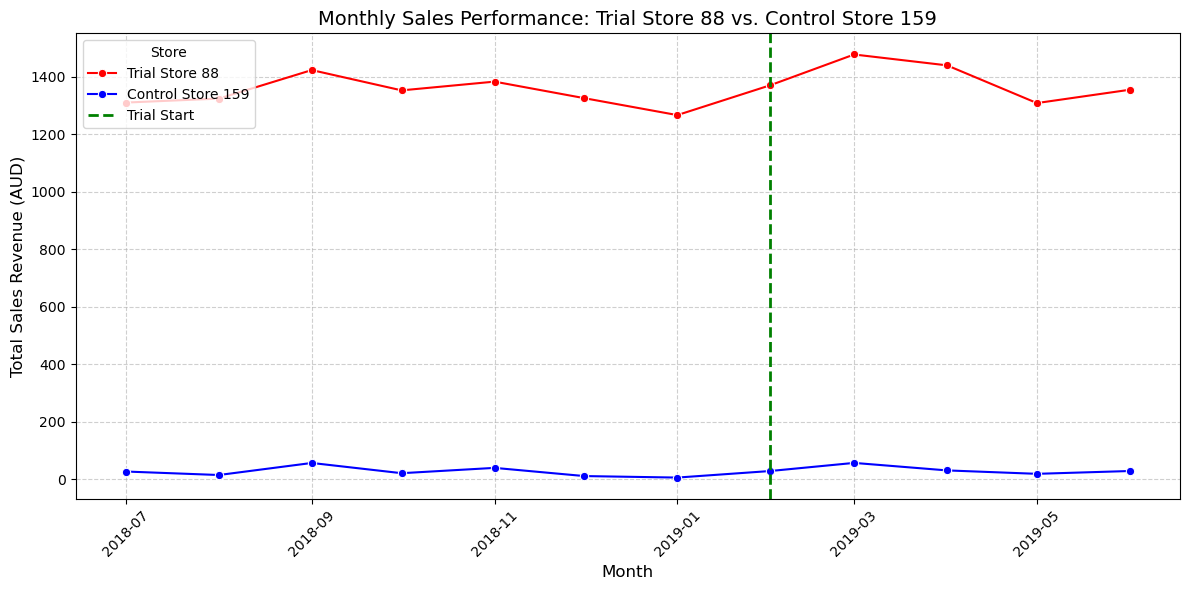

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the stores for visualization (Store 88 and its control 159)
TRIAL_STORE = 88
CONTROL_STORE = 159

# Combine pre-trial and trial data for plotting
plot_data = monthly_data[monthly_data['STORE_NBR'].isin([TRIAL_STORE, CONTROL_STORE])].copy()
plot_data['Store_Type'] = plot_data['STORE_NBR'].apply(
    lambda x: f'Trial Store {TRIAL_STORE}' if x == TRIAL_STORE else f'Control Store {CONTROL_STORE}'
)

# Convert YEAR_MONTH back to datetime for cleaner plotting on x-axis
plot_data['YEAR_MONTH_DT'] = plot_data['YEAR_MONTH'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=plot_data,
    x='YEAR_MONTH_DT',
    y='Monthly_Total_Sales',
    hue='Store_Type',
    palette=['red', 'blue'],
    marker='o'
)

# Add a vertical line to mark the start of the trial
trial_start_dt = pd.to_datetime(TRIAL_START_DATE)
plt.axvline(trial_start_dt, color='green', linestyle='--', linewidth=2, label='Trial Start')

plt.title(f'Monthly Sales Performance: Trial Store {TRIAL_STORE} vs. Control Store {CONTROL_STORE}', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales Revenue (AUD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Store', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f'Trial_Impact_Sales_Store_{TRIAL_STORE}_vs_{CONTROL_STORE}.png')
plt.show()